Bilayer unit domain. Sigma optimisation

In [106]:
import matplotlib.pyplot as plt

try:
	if "science" not in plt.style.available:
		try:
			import scienceplots  # registers styles if installed
		except Exception:
			# Install SciencePlots (registers the 'science' style) and import it
			get_ipython().run_line_magic('pip', 'install -q SciencePlots')
			import scienceplots  # noqa: F401
	plt.style.use(["science", "grid"])
except Exception as e:
	# If anything fails, fall back to a commonly available style
	print("Warning: 'science' style not available. Using 'seaborn' instead. Error:", e)
	plt.style.use("seaborn")

In [107]:
import matplotlib as mpl
colors_list = [
    "#0C5DA5",  # blue
    "#00B945",  # green
    "#FF9500",  # orange
    "#FF2C00",  # red
    "#845B97",  # purple
    "#474747",  # dark gray
    "#9e9e9e",  # light gray
]

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=colors_list)

mpl.rcParams.update({
    # Tamaño físico
    "figure.figsize": (2.9, 2.6),

    # Líneas
    "lines.linewidth": 2.0,
    "lines.markersize": 8,

    # Fuente de títulos, labels y leyendas
    "font.size": 23,
    "axes.labelsize": 23,
    "axes.titlesize": 23,
    "legend.fontsize": 20,

    # Números de los ejes un pelín más pequeños
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,

    # Ejes y ticks
    "axes.linewidth": 1.4,
    "xtick.major.width": 1.4,
    "ytick.major.width": 1.4,

    # PDF limpio
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


In [108]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, assemble_scalar
import basix
from dolfinx.geometry import bb_tree
from dolfinx import geometry
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [109]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [110]:
import numpy as np

pml_profile = "constant"

data = np.load(
    f"./NPZ/results_sigma_optimization_{pml_profile}.npz",
    allow_pickle=True
)

pml_thickness = data["pml_thickness"]
Lx = data["Lx"]
l_inner = data["l_inner"]

rho_media_1 = data["rho_media_1"]
rho_media_2 = data["rho_media_2"]
vel_media_1 = data["vel_media_1"]
vel_media_2 = data["vel_media_2"]

sigma_sweep = data["sigma_sweep"]

rel_err_eig_sigma_sweep = data["rel_err_eig_sigma_sweep"]
rel_err_p_sigma_sweep = data["rel_err_p_sigma_sweep"]
rel_err_v_sigma_sweep = data["rel_err_v_sigma_sweep"]
rel_err_total_sigma_sweep = data["rel_err_total_sigma_sweep"]

h = data["h"].astype(float)
N = data["N"].astype(int)

exact_omega = data["exact_omega"]
approx_omega = data["approx_omega"]

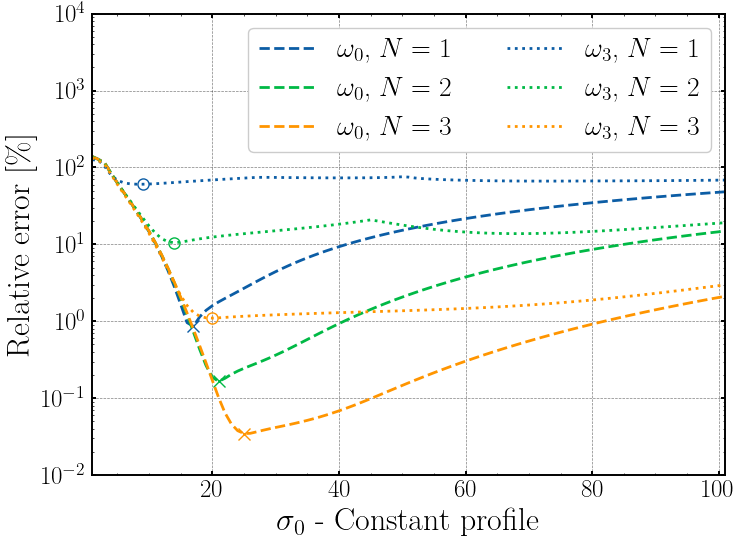

In [111]:
linestyles = {0: '--', 3: ':'}
markers= {0: 'x', 3: 'o'}
labels = {0: r'$\omega_0$', 3: r'$\omega_3$'}

match pml_profile:
    case "constant":
        uppercase_name="Constant"
    case "quadratic":
        uppercase_name="Quadratic"
    case "singular":
        uppercase_name="Singular"


fig, ax = plt.subplots(figsize=(8, 6))
err_tot = rel_err_total_sigma_sweep.tolist()

for j in [0, 3]:            # modos físicos
    for i, N_index in enumerate(N):
        col = colors_list[i % len(colors_list)]
        ls = linestyles[j]

        errs = err_tot[j][N_index]

        ax.plot(
            sigma_sweep,
            errs,
            color=col,
            linestyle=ls,
            label=rf"{labels[j]}, $N={N_index}$"
        )

        # mínimo
        k = np.argmin(errs)
        ax.plot(
            sigma_sweep[k],
            errs[k],
            markers[j],
            color=col,
            markersize=8,  markerfacecolor='none'
                )

ax.set_yscale('log')
ax.set_xlabel(f'$\sigma_0$ - {uppercase_name} profile')
ax.set_ylabel(r'Relative error [\%]')
ax.grid(True)
ax.set_xlim([sigma_sweep[0], sigma_sweep[-1]])
# lenda sen duplicados
handles, labels_leg = ax.get_legend_handles_labels()
by_label = dict(zip(labels_leg, handles))
ax.legend(by_label.values(), by_label.keys(), ncol=2, loc='upper right')
ax.set_ylim([10e-3,10e3])
# plt.suptitle(
#     f'$\sigma_0$ optimization depending on $\omega$ and N values. PML profile {pml_profile}.',
#     fontsize=14
# )

plt.tight_layout()
# plt.savefig(f"sigma_optimization_total_{pml_profile}.png", dpi=300)
plt.savefig(f"1D_bicapa_optimo_{pml_profile}.pdf", dpi=300)

plt.show()
